# **Python assignment**

In [30]:
# ---------------------------------------------------------
# File Name: MidTermAssignment.py
# Description: 
# Autor: Prat Paul; Gavini Charles; Fournier Justin; Blanc Mathieu
# Creation Date: 2024-10-16
# Version: 1.0
# ---------------------------------------------------------

Installing yahoofinance

In [31]:
#pip install yfinance

Installing statsmodels

In [32]:
#pip install statsmodels

In [33]:
#importations
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf # import this function from this submodule
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
import scipy.signal as ss
import pylab

# *First pandas dataframe of Nvidia stocks*

In [88]:
# Importing Nvidia stock from yahoo finance
Nvidia = yf.download("NVDA", start="1999-01-21", end="2024-10-16")
Nvidia.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037618,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041559,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038334,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038215,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038095,227520000


In [35]:
#pip install perfplot

In [37]:
latex_table = Nvidia.head().to_latex(index=True)
with open("Latex/table.tex", "w") as file:
    file.write(latex_table)

/var/folders/5r/ft807c7n1ngd3fpt2_gwsg0m0000gn/T/ipykernel_58295/210123375.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = Nvidia.head().to_latex(index=True)


# *Cheking if timestamp is 25 years*

In [92]:
print('Nvidia data range is: ',Nvidia.index[0],Nvidia.index[-1])

#trying to find gaps

#First create a dataframe for a fullrange of our index, without any gap with the following formula: 
full_range = pd.date_range(start=Nvidia.index.min(), end=Nvidia.index.max(), freq='B')

#Then compare to our dataframe: 

MissingDays=full_range.difference(Nvidia.index)

#Print the count and the detail preview:
print('Missing Days count is: ',len(MissingDays))
print("missing dates",MissingDays)

#We can see that data have ponctual gaps, no issue here we can still use it

Nvidia data range is:  1999-01-22 00:00:00 2024-10-15 00:00:00
Missing Days count is:  238
missing dates DatetimeIndex(['1999-02-15', '1999-04-02', '1999-05-31', '1999-07-05',
               '1999-09-06', '1999-11-25', '1999-12-24', '2000-01-17',
               '2000-02-21', '2000-04-21',
               ...
               '2023-11-23', '2023-12-25', '2024-01-01', '2024-01-15',
               '2024-02-19', '2024-03-29', '2024-05-27', '2024-06-19',
               '2024-07-04', '2024-09-02'],
              dtype='datetime64[ns]', length=238, freq=None)


In [39]:
Nvidia.index
#extracting adjusted
Nv_adj=Nvidia['Adj Close']
Nv_adj.index = Nvidia.index

#display first 5 rows, now it is a pandas series instead of a dataframe
Nv_adj.head()

Date
1999-01-22    0.037618
1999-01-25    0.041559
1999-01-26    0.038334
1999-01-27    0.038215
1999-01-28    0.038095
Name: Adj Close, dtype: float64

For the possible gaps in data, we plot them here

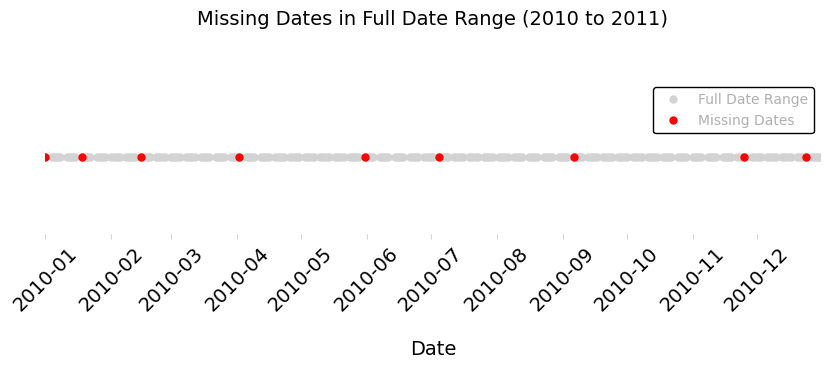

In [123]:
#plot the missing dates
full_data = Nvidia.reindex(full_range)

#zoom in over one year
start_date = "2010-01-01"
end_date = "2011-01-01"
filtered_full_range = full_range[(full_range >= start_date) & (full_range <= end_date)]
filtered_missing_dates = MissingDays[(MissingDays >= start_date) & (MissingDays <= end_date)]

plt.figure(figsize=(10, 2))

# Plot all dates in the filtered range with gray dots (showing the full timeline for this period)
plt.plot(filtered_full_range, [1] * len(filtered_full_range), 'o', color='lightgray', markersize=5, label="Full Date Range")

# Overlay red dots only on the missing dates within the filtered range
plt.plot(filtered_missing_dates, [1] * len(filtered_missing_dates), 'ro', markersize=5, label="Missing Dates")

# Customize plot
plt.title("Missing Dates in Full Date Range (2010 to 2011)",color='black')
plt.xlabel("Date",color='black')
plt.yticks([])  # Hide y-axis labels for clarity
plt.xticks(rotation=45,color='black')
plt.legend(facecolor='white', edgecolor='black', framealpha=1, fontsize=10)

#Saving the plot in pdf format
plt.savefig('Latex/Img/MissingDates(2010_to_2011).pdf', format='pdf', bbox_inches='tight')

plt.show()


# *Calculating returns*

In [1]:
#calculating return

"""
TODO
"""

'\nTODO\n'

Adding python code to the latex document in the appendix part

In [41]:
#Test for incorporating python code into the appendix section in the latex document
code_content = r"""
\section{Appendix: Python Code}
Below is the Python code used in this analysis.

\begin{lstlisting}[language=Python, caption=Python Code for Analysis]
# Python code example
import numpy as np
import pandas as pd

def analyze_data(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

data = [1, 2, 3, 4, 5]
mean, std_dev = analyze_data(data)
print(f"Mean: {mean}, Standard Deviation: {std_dev}")
\end{lstlisting}
"""

# Write to the 'code_appendix.tex' file
with open("Latex/code_appendix.tex", "w") as file:
    file.write(code_content)